# Motivating Example

This includes a small testcase made up based on a Juliet example. The aim is to make it small enough that its raw code, ast, cpg, and prolog representation can be included in a write-up without being too cumbersome.

In [17]:
import os
import subprocess
import tempfile
import collections
import preprocess_code
import pandas as pd
import graph_visualisation as gv

from IPython.display import Image

In [18]:
def save_png_and_svg_then_render_dot_graph(dot_source, filename_no_ext):
    tmp_file = open(filename_no_ext, "w", encoding="utf-8")
    tmp_file.write(dot_source)
    tmp_file.close()
    
    gv.render_graph(filename_no_ext, filetype='svg')
    gv.render_graph(filename_no_ext, filetype='png')
    
    image = Image(filename=filename_no_ext + ".png", embed=True, format='png')

    return image

In [19]:
ilp_data = pd.read_csv("../data/ilp_dataset.csv.gz")
ilp_data = ilp_data.drop('Unnamed: 0', axis='columns')
ilp_data.sort_values('code_length').head()

,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
22,-62852,000/062/852/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,True,1570
30,-62900,000/062/900/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,True,1576
29,-62869,000/062/869/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,32,True,1616
20,-62804,000/062/804/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,True,1618
38,-232012,000/232/012/CWE122_Heap_Based_Buffer_Overflow_...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-122,31,True,1619


In [20]:
example_testcase = ilp_data[
    (ilp_data['testcase_ID'] == 62852)
    | (ilp_data['testcase_ID'] == -62852)
]

In [21]:
print(example_testcase.iloc[0].code)

/* TEMPLATE GENERATED TESTCASE FILE
Filename: CWE121_Stack_Based_Buffer_Overflow__CWE131_memcpy_01.c
Label Definition File: CWE121_Stack_Based_Buffer_Overflow__CWE131.label.xml
Template File: sources-sink-01.tmpl.c
*/
/*
 * @description
 * CWE: 121 Stack Based Buffer Overflow
 * BadSource:  Allocate memory without using sizeof(int)
 * GoodSource: Allocate memory using sizeof(int)
 * Sink: memcpy
 *    BadSink : Copy array to data using memcpy()
 * Flow Variant: 01 Baseline
 *
 * */

#include "std_testcase.h"


#ifndef OMITGOOD

/* goodG2B uses the GoodSource with the BadSink */
static void goodG2B()
{
    int * data;
    data = NULL;
    /* FIX: Allocate memory using sizeof(int) */
    data = (int *)ALLOCA(10*sizeof(int));
    {
        int source[10] = {0};
        /* POTENTIAL FLAW: Possible buffer overflow if data was not allocated correctly in the source */
        memcpy(data, source, 10*sizeof(int));
        printIntLine(data[0]);
    }
}

void CWE121_Stack_Based_Buffer_Overflow_

Handwritten, minimal versions:

In [22]:
good_code = """int main() {
    int * data = (int *)ALLOCA(10*sizeof(int));
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}
"""
bad_code = """int main() {
    int * data = (int *)ALLOCA(10);
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}
"""

In [23]:
example_testcase.loc[example_testcase['bug'] == False,'code'] = good_code
example_testcase.loc[example_testcase['bug'] == False,'code_length'] = len(good_code)
example_testcase.loc[example_testcase['bug'] == False,'filename'] = "motivating_example_good.c"

example_testcase.loc[example_testcase['bug'] == True,'code'] = bad_code
example_testcase.loc[example_testcase['bug'] == True,'code_length'] = len(bad_code)
example_testcase.loc[example_testcase['bug'] == True,'filename'] = "motivating_example_bad.c"

example_testcase

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
2,62852,motivating_example_good.c,int main() {\n int * data = (int *)ALLOCA(1...,CWE-121,30,False,141
22,-62852,motivating_example_bad.c,int main() {\n int * data = (int *)ALLOCA(1...,CWE-121,30,True,129


### Visualisation of Clang AST

Start with a clang ast:

In [24]:
good_ast = preprocess_code.generate_ast_roots(
    example_testcase.loc[example_testcase['bug'] == False]
)
bad_ast = preprocess_code.generate_ast_roots(
    example_testcase.loc[example_testcase['bug'] == True]
)

In [25]:
def get_source_code(ast_node, source):
    region = ast_node.extent
    
    # convert columns and lines to 0 based indexing
    start_line = region.start.line
    start_column = region.start.column - 1
    end_line = region.end.line
    end_column = region.end.column - 1 
    
    # extract lines
    lines = source.split("\n")[start_line:end_line+1]
    
    # trim the first and last lines based on column
    lines[0] = lines[0][start_column:]
    lines[-1] = lines[-1][:end_column+1]
    
    return "\n".join(lines).strip()

def make_dot_edge(edge):
    start, end = edge
    return start + " -> " + end

def generate_features(ast_root, source_code):
    """
    Modified version of preprocess_code.generate_features() 
    with output better for visualisation.
    """
    features = {}

    def walk_tree_and_set_features(node):        
        out_degree = len(node.children)
        in_degree = 1
        degree = out_degree + in_degree
        
        try:
            name = get_source_code(node, source_code)
        except:
            name = node.displayname or node.spelling or node.mangled_name

        features[node.identifier] = [degree, str(node.kind), name]

        for child in node.children:
            walk_tree_and_set_features(child)

    walk_tree_and_set_features(ast_root)

    return features


def clang_ast_to_dot(ast_root, source_code):
    ast_edgelist = '\n                '.join([
        make_dot_edge((str(start), str(end)))
        for start, end in preprocess_code.generate_edgelist(ast_root)
    ])
    node_labels = '\n                '.join([
        str(node_id)
        + ' [label="' + str(node_features[1].replace("CursorKind.", "")) + '\n' 
        + str(node_features[2])
        + '"]'
        for node_id, node_features in generate_features(ast_root, source_code).items()
    ])
    return """
        digraph g {
            {  # NODE LABELS
                node[shape=box]
                """ + node_labels + """
            }
            {  # AST
                edge[color=green3, constraint=true]
                """ + ast_edgelist + """
            }
        }
    """

In [29]:
good_clang_dot = clang_ast_to_dot(good_ast, good_code)
print(good_clang_dot)


        digraph g {
            {  # NODE LABELS
                node[shape=box]
                1 [label="TRANSLATION_UNIT
int * data = (int *)ALLOCA(10*sizeof(int));
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}"]
                2 [label="FUNCTION_DECL
int * data = (int *)ALLOCA(10*sizeof(int));
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}"]
                3 [label="COMPOUND_STMT
ata = (int *)ALLOCA(10*sizeof(int));
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}"]
                4 [label="DECL_STMT
"]
                5 [label="VAR_DECL
"]
                6 [label="CSTYLE_CAST_EXPR
"]
                7 [label="CALL_EXPR
"]
                8 [label="UNEXPOSED_EXPR
"]
                9 [label="DECL_REF_EXPR
"]
                10 [label="BINARY_OPERATOR
"]
                11 [label="UNEXPOSED_EXPR
"]
                12 [label="INTEGER_LITERAL
"]
                13 [label="CXX_UNARY_E

Manually edit to look nicer:

In [30]:
good_clang_dot = """
        digraph g {
            {  # NODE LABELS
                node[shape=box]
                1 [label="TRANSLATION_UNIT
good_example.c"]
                2 [label="FUNCTION_DECL
int main() {...}"]
                3 [label="COMPOUND_STMT
    int * data = (int *)ALLOCA(10*sizeof(int));
    int source[10] = {0};
    memcpy(data, source, 10*sizeof(int));"]
                4 [label="DECL_STMT
int * data = (int *)ALLOCA(10*sizeof(int));"]
                5 [label="VAR_DECL
int * data = (int *)ALLOCA(10*sizeof(int));"]
                6 [label="CSTYLE_CAST_EXPR
(int *)ALLOCA(10*sizeof(int));"]
                7 [label="CALL_EXPR
ALLOCA(10*sizeof(int));"]
                8 [label="UNEXPOSED_EXPR
ALLOCA"]
                9 [label="DECL_REF_EXPR
ALLOCA"]
                10 [label="BINARY_OPERATOR
10*sizeof(int));"]
                11 [label="UNEXPOSED_EXPR
10"]
                12 [label="INTEGER_LITERAL
10"]
                13 [label="CXX_UNARY_EXPR
sizeof(int));"]
                14 [label="DECL_STMT
int source[10] = {0};"]
                15 [label="VAR_DECL
int source[10] = {0};"]
                16 [label="INTEGER_LITERAL
10"]
                17 [label="INIT_LIST_EXPR
{0}"]
                18 [label="INTEGER_LITERAL
0"]
                19 [label="CALL_EXPR
memcpy(data, source, 10*sizeof(int));"]
                20 [label="UNEXPOSED_EXPR
memcpy"]
                21 [label="DECL_REF_EXPR
memcpy"]
                22 [label="UNEXPOSED_EXPR
data"]
                23 [label="UNEXPOSED_EXPR
data"]
                24 [label="DECL_REF_EXPR
data"]
                25 [label="UNEXPOSED_EXPR
source"]
                26 [label="UNEXPOSED_EXPR
source"]
                27 [label="DECL_REF_EXPR
source"]
                28 [label="BINARY_OPERATOR
10*sizeof(int));"]
                29 [label="UNEXPOSED_EXPR
10"]
                30 [label="INTEGER_LITERAL
10"]
                31 [label="CXX_UNARY_EXPR
sizeof(int));"]
            }
            {  # AST
                edge[color=green3, constraint=true]
                1 -> 2
                2 -> 3
                3 -> 4
                4 -> 5
                5 -> 6
                6 -> 7
                7 -> 8
                8 -> 9
                7 -> 10
                10 -> 11
                11 -> 12
                10 -> 13
                3 -> 14
                14 -> 15
                15 -> 16
                15 -> 17
                17 -> 18
                3 -> 19
                19 -> 20
                20 -> 21
                19 -> 22
                22 -> 23
                23 -> 24
                19 -> 25
                25 -> 26
                26 -> 27
                19 -> 28
                28 -> 29
                29 -> 30
                28 -> 31
            }
        }
"""

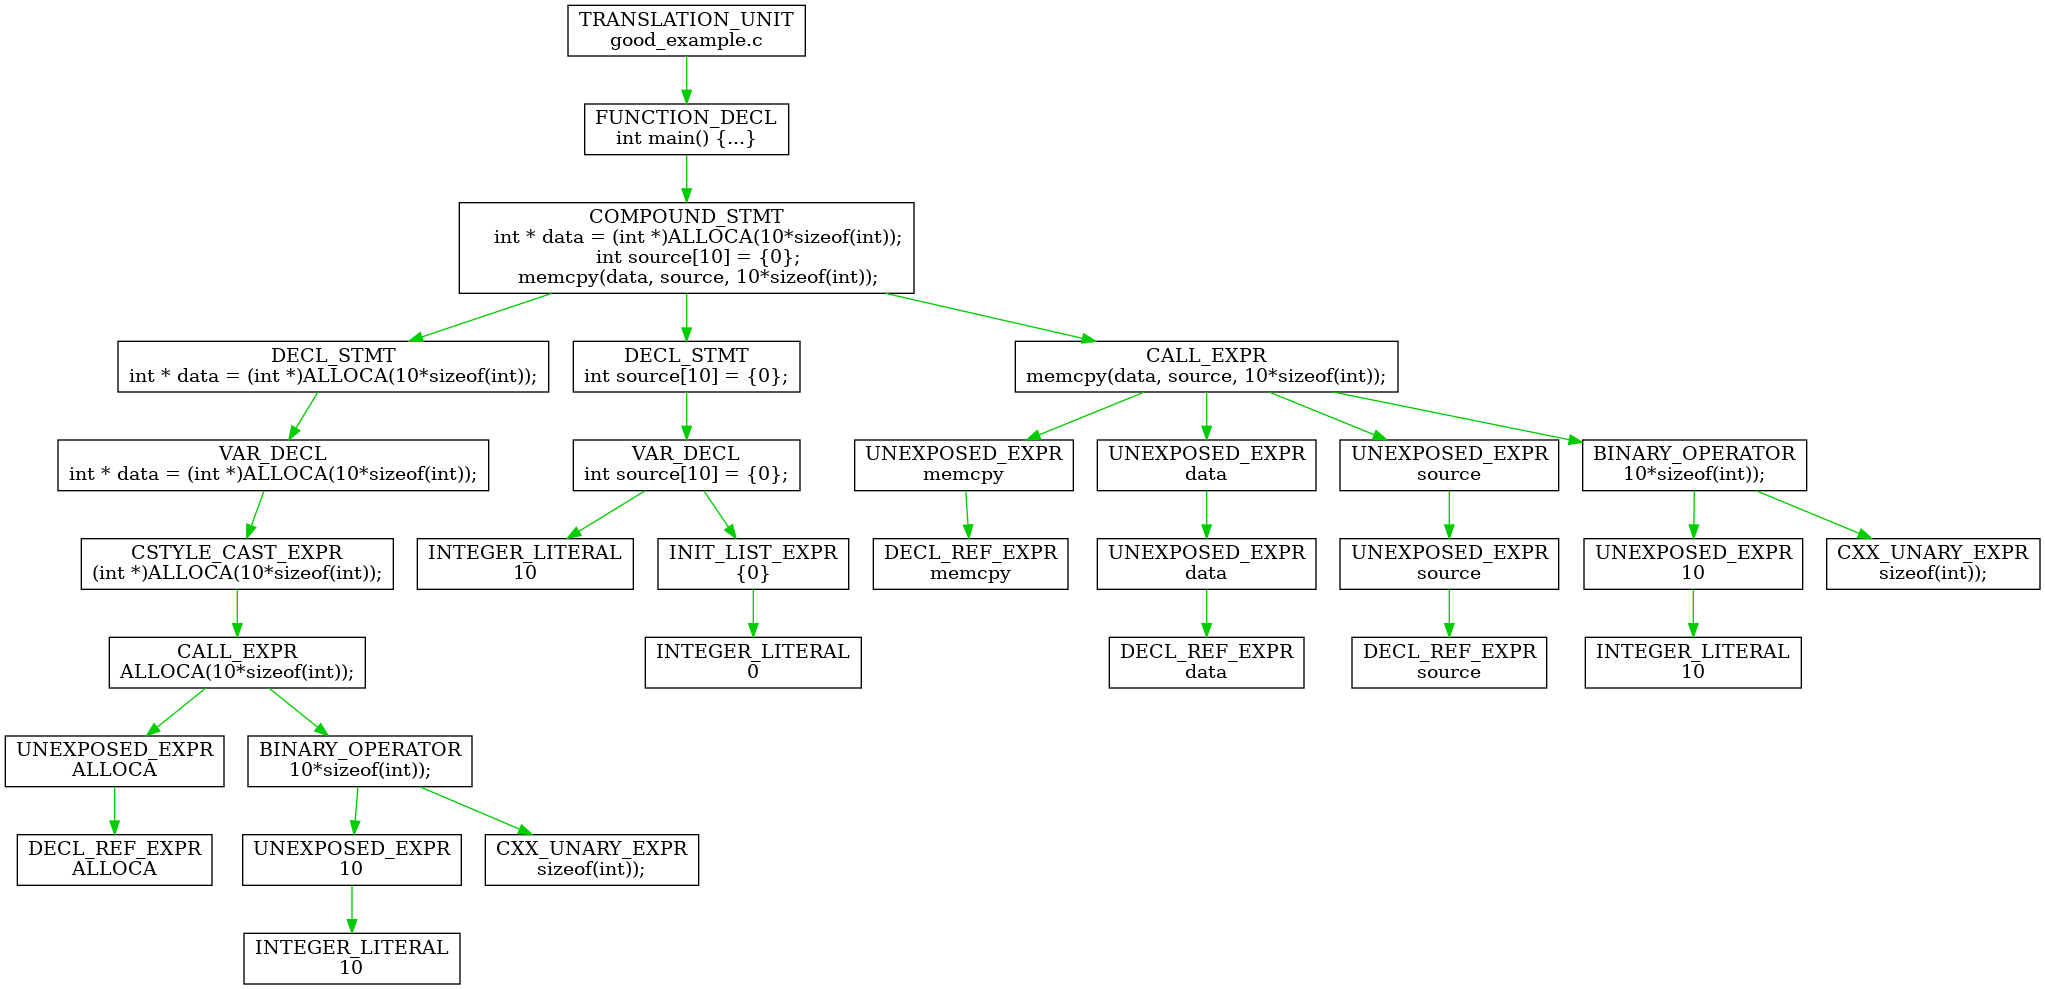

In [28]:
save_png_and_svg_then_render_dot_graph(
    good_clang_dot,
    "motivating-example-good-nn-ast"
)

Do the same for the buggy example:

In [31]:
bad_clang_dot = clang_ast_to_dot(bad_ast, bad_code)
print(bad_clang_dot)


        digraph g {
            {  # NODE LABELS
                node[shape=box]
                1 [label="TRANSLATION_UNIT
int * data = (int *)ALLOCA(10);
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}"]
                2 [label="FUNCTION_DECL
int * data = (int *)ALLOCA(10);
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}"]
                3 [label="COMPOUND_STMT
ata = (int *)ALLOCA(10);
    
    int source[10] = {0};
    
    memcpy(data, source, 10*sizeof(int));
}"]
                4 [label="DECL_STMT
"]
                5 [label="VAR_DECL
"]
                6 [label="CSTYLE_CAST_EXPR
"]
                7 [label="CALL_EXPR
"]
                8 [label="UNEXPOSED_EXPR
"]
                9 [label="DECL_REF_EXPR
"]
                10 [label="INTEGER_LITERAL
"]
                11 [label="DECL_STMT
"]
                12 [label="VAR_DECL
"]
                13 [label="INTEGER_LITERAL
"]
                14 [label="INIT_LIST_EXP

In [32]:
bad_clang_dot = """

        digraph g {
            {  # NODE LABELS
                node[shape=box]
                1 [label="TRANSLATION_UNIT
bad_example.c"]
                2 [label="FUNCTION_DECL
int main() {...}"]
                3 [label="COMPOUND_STMT
    int * data = (int *)ALLOCA(10);
    int source[10] = {0};
    memcpy(data, source, 10*sizeof(int));"]
                4 [label="DECL_STMT
int * data = (int *)ALLOCA(10);"]
                5 [label="VAR_DECL
int * data = (int *)ALLOCA(10);"]
                6 [label="CSTYLE_CAST_EXPR
(int *)ALLOCA(10);"]
                7 [label="CALL_EXPR
ALLOCA(10);"]
                8 [label="UNEXPOSED_EXPR
ALLOCA"]
                9 [label="DECL_REF_EXPR
ALLOCA"]
                10 [label="INTEGER_LITERAL
10"]
                11 [label="DECL_STMT
int source[10] = {0};"]
                12 [label="VAR_DECL
int source[10] = {0};"]
                13 [label="INTEGER_LITERAL
10"]
                14 [label="INIT_LIST_EXPR
{0}"]
                15 [label="INTEGER_LITERAL
0"]
                16 [label="CALL_EXPR
memcpy(data, source, 10*sizeof(int));"]
                17 [label="UNEXPOSED_EXPR
memcpy"]
                18 [label="DECL_REF_EXPR
memcpy"]
                19 [label="UNEXPOSED_EXPR
data"]
                20 [label="UNEXPOSED_EXPR
data"]
                21 [label="DECL_REF_EXPR
data"]
                22 [label="UNEXPOSED_EXPR
source"]
                23 [label="UNEXPOSED_EXPR
source"]
                24 [label="DECL_REF_EXPR
source"]
                25 [label="BINARY_OPERATOR
10*sizeof(int));"]
                26 [label="UNEXPOSED_EXPR
10"]
                27 [label="INTEGER_LITERAL
10"]
                28 [label="CXX_UNARY_EXPR
sizeof(int));"]
            }
            {  # AST
                edge[color=green3, constraint=true]
                1 -> 2
                2 -> 3
                3 -> 4
                4 -> 5
                5 -> 6
                6 -> 7
                7 -> 8
                8 -> 9
                7 -> 10
                3 -> 11
                11 -> 12
                12 -> 13
                12 -> 14
                14 -> 15
                3 -> 16
                16 -> 17
                17 -> 18
                16 -> 19
                19 -> 20
                20 -> 21
                16 -> 22
                22 -> 23
                23 -> 24
                16 -> 25
                25 -> 26
                26 -> 27
                25 -> 28
            }
        }
"""

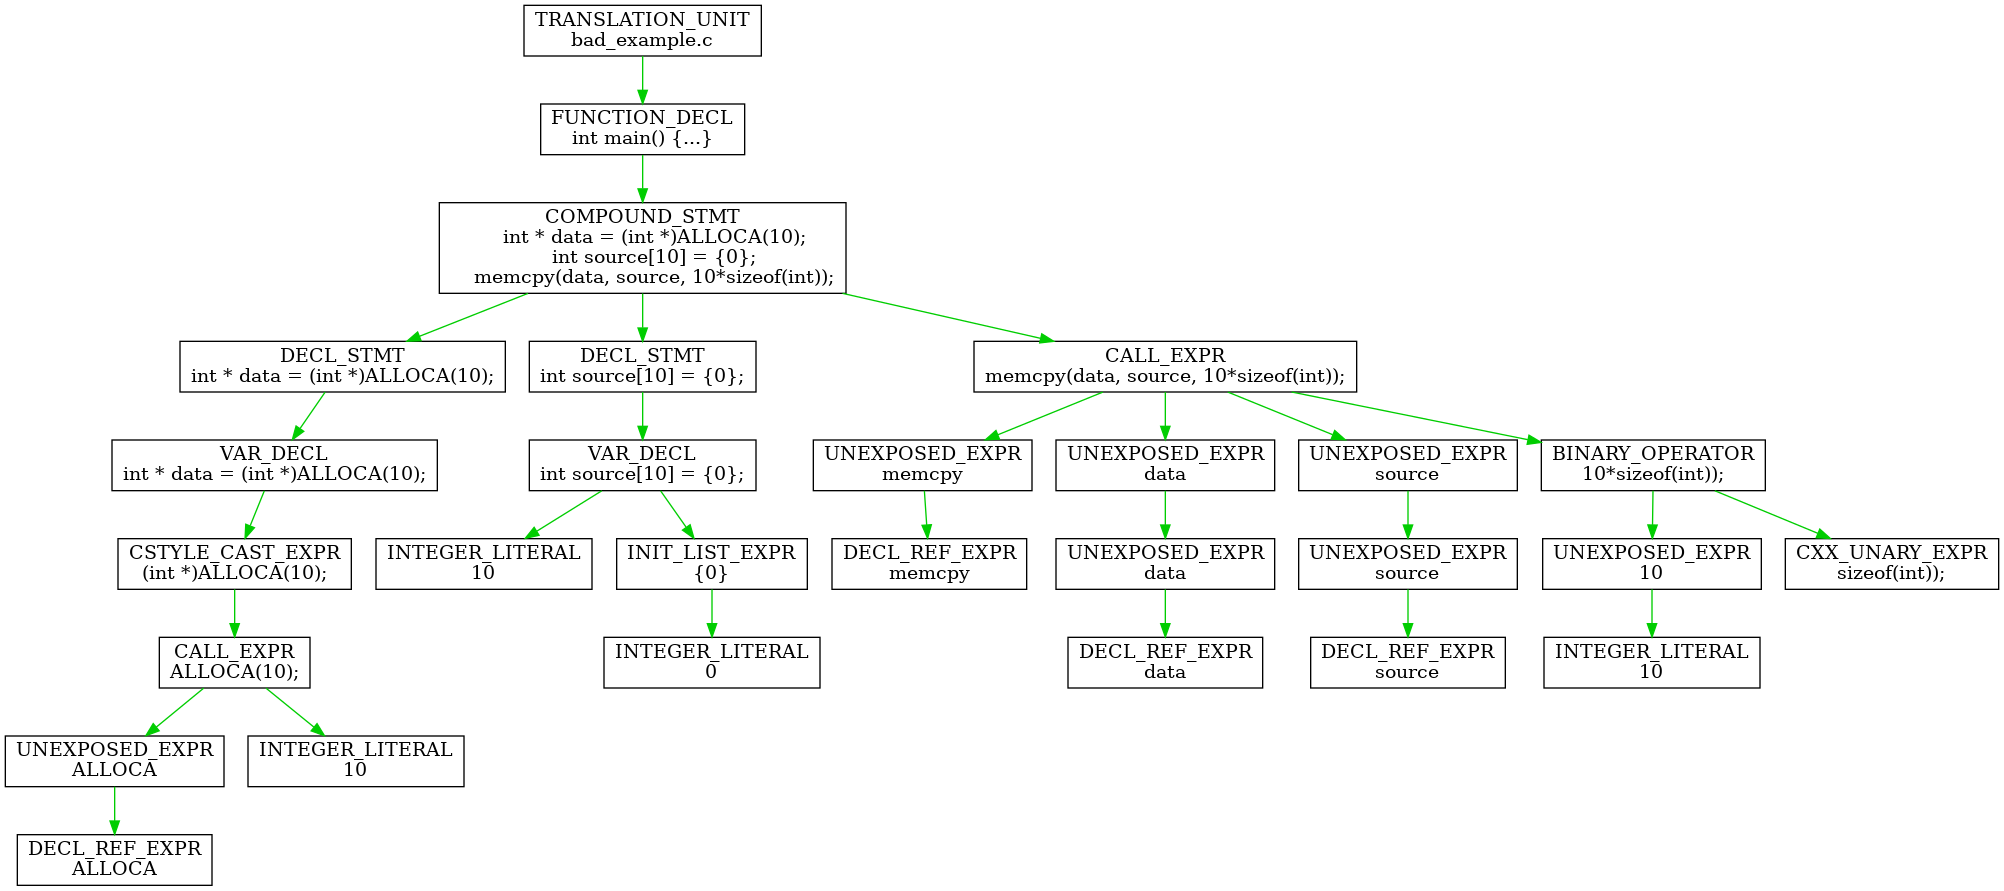

In [33]:
save_png_and_svg_then_render_dot_graph(
    bad_clang_dot,
    "motivating-example-bad-nn-ast"
)

### Visualisation of CPG

First we need to run Joern on it, then run our utility functions to convert it to Prolog, then those to convert it to dot format....

In [36]:
testcase_IDs = []
flaws = []
bugs = []
codes = []
dots = []

def generate_prolog(testcase):
    tmp_dir = tempfile.TemporaryDirectory()

    for file in testcase.itertuples():
        short_filename = file.filename.split("/")[-1]
        with open(tmp_dir.name + "/" + short_filename, 'w') as f:
            f.write(file.code)

    subprocess.check_call(["/joern/joern-parse", "--out", tmp_dir.name + "/cpg.bin.zip", tmp_dir.name])
    
    code = subprocess.check_output(
        "cd /joern && /joern/joern-query --cpg " + tmp_dir.name + "/cpg.bin.zip -f /project/code/ILP-joern-cfg-to-prolog.scala",
        shell=True,
        universal_newlines=True,
    )

    dot = subprocess.check_output(
        "cd /joern && /joern/joern-query --cpg " + tmp_dir.name + "/cpg.bin.zip -f /project/code/ILP-joern_cfg_to_dot.scala",
        shell=True,
        universal_newlines=True,
    )

    testcase_IDs.append(file.testcase_ID)
    flaws.append( file.flaw)
    bugs.append(file.bug)
    codes.append(code)
    dots.append(dot)

    tmp_dir.cleanup()
    
example_testcase.groupby('testcase_ID').apply(generate_prolog)

prolog = pd.DataFrame({
    'testcase_ID': testcase_IDs,
    'flaw': flaws,
    'bug': bugs,
    'codes': codes,
    'dots': dots,
})
prolog = prolog[1:]  # when we run apply it duplicates the first group
prolog

,testcase_ID,flaw,bug,codes,dots
1,-62852,CWE-121,True,% START: Generated Prolog\n% NODE PROPERTIES \...,"digraph g {\n# AST\n{\n edge[color=green3,con..."
2,62852,CWE-121,False,% START: Generated Prolog\n% NODE PROPERTIES \...,"digraph g {\n# AST\n{\n edge[color=green3,con..."


The main graph is in the center of each of these, while the small AST's on the left, and the group of functions at the right aren't interesting. For the purposes of digestibility, cut it down to the bits we care about by removing the "function call" edges, and those nodes which are only connected via "function call edges".

I did this by temporarily commenting out the "CALL" section from the `ILP-joern_cfg_to_dot.scala` script

CPG of fixed example:

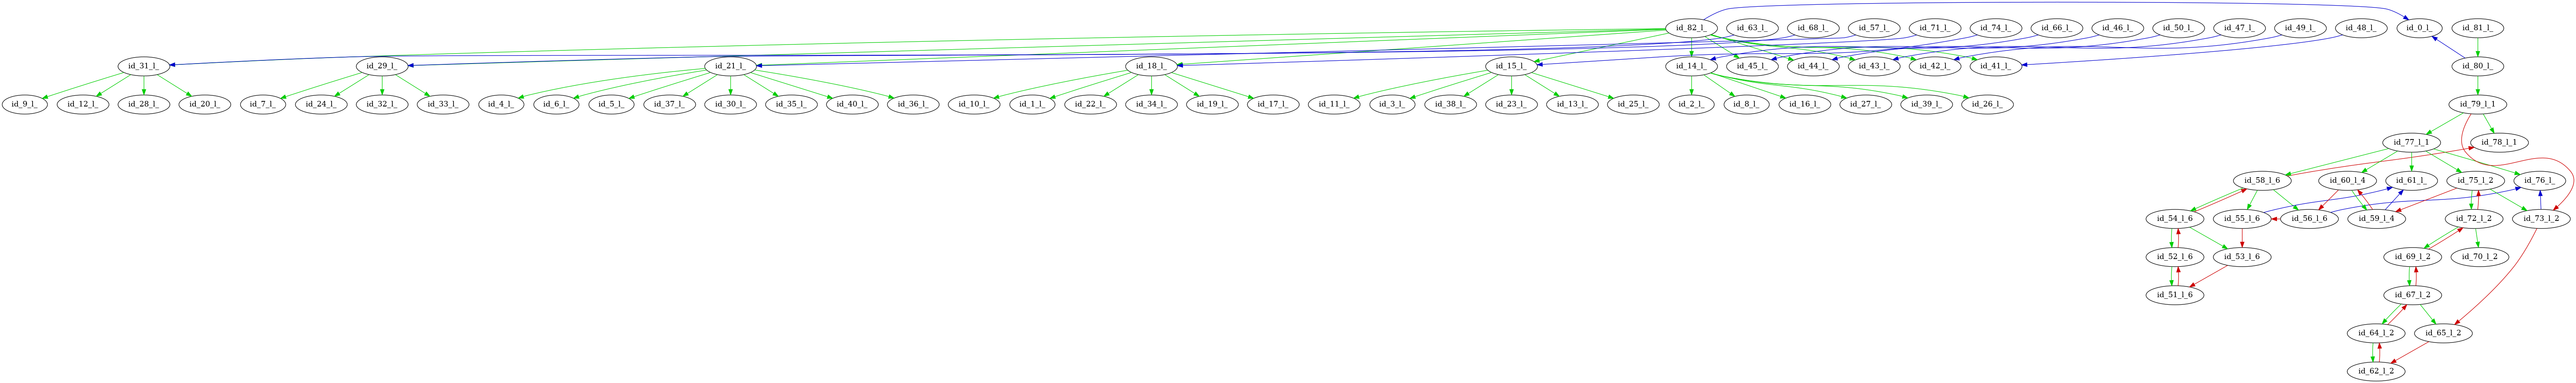

In [37]:
gv.jupyter_display_graph(prolog[prolog['bug'] == False].iloc[0].dots)

CPG of buggy example:

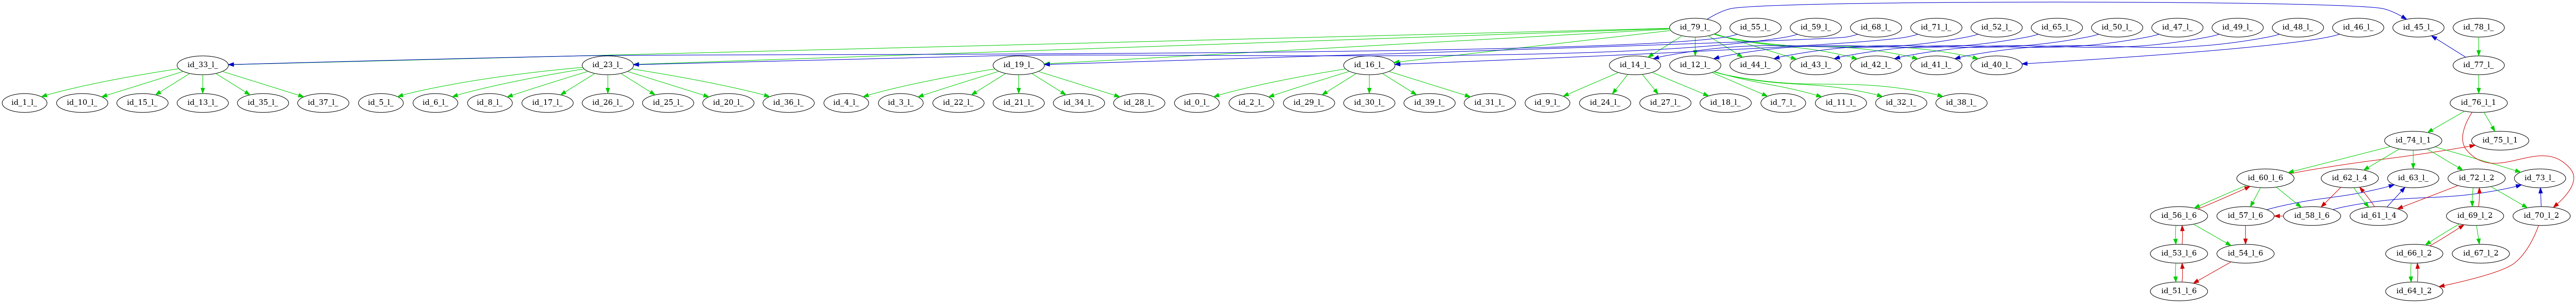

In [38]:
gv.jupyter_display_graph(prolog[prolog['bug'] == True].iloc[0].dots)

Next remove all the bits on the left hand side, do this via manual editing.

Manually pruned fixed example, based on `prolog[prolog['bug'] == False].iloc[0].dots`:

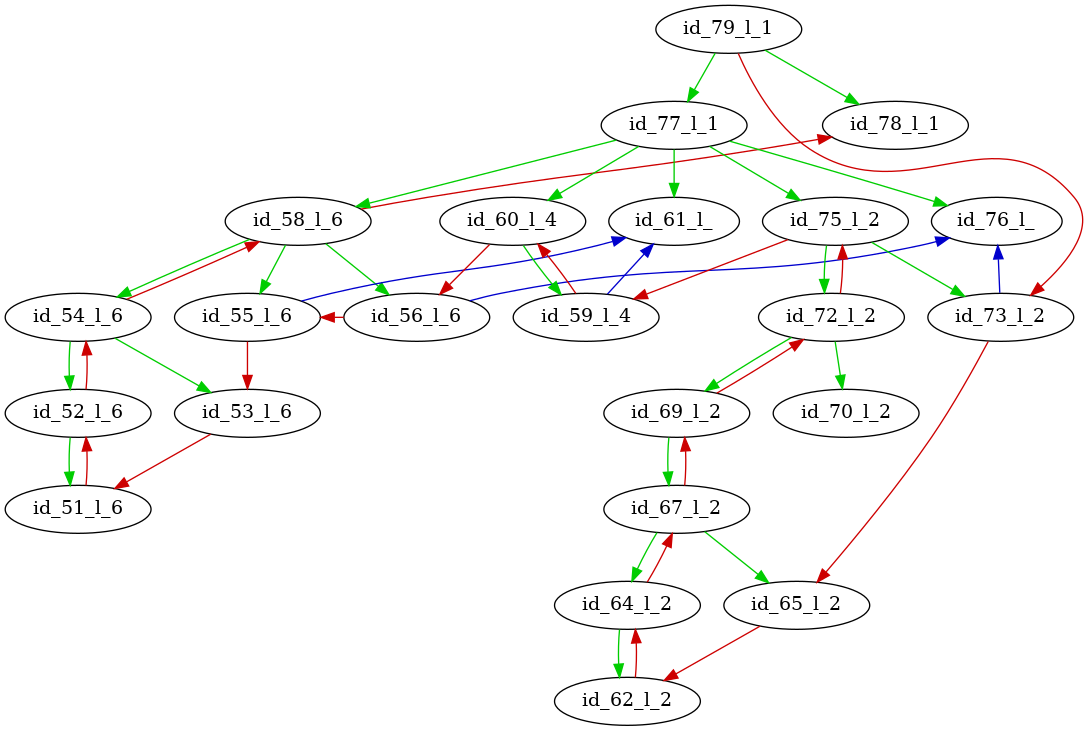

In [39]:
good_example_cpg_for_ilp = """
digraph g {
# AST
{
  edge[color=green3,constraint=true]
  id_52_l_6 -> id_51_l_6 
   id_54_l_6 -> id_52_l_6 
   id_54_l_6 -> id_53_l_6 
   id_58_l_6 -> id_54_l_6 
   id_58_l_6 -> id_55_l_6 
   id_58_l_6 -> id_56_l_6 
   id_77_l_1 -> id_58_l_6 
   id_60_l_4 -> id_59_l_4 
   id_77_l_1 -> id_60_l_4 
   id_77_l_1 -> id_61_l_ 
   id_64_l_2 -> id_62_l_2 
   id_67_l_2 -> id_64_l_2 
   id_67_l_2 -> id_65_l_2 
   id_69_l_2 -> id_67_l_2 
   id_72_l_2 -> id_69_l_2 
   id_72_l_2 -> id_70_l_2 
   id_75_l_2 -> id_72_l_2 
   id_75_l_2 -> id_73_l_2 
   id_77_l_1 -> id_75_l_2 
   id_77_l_1 -> id_76_l_ 
   id_79_l_1 -> id_77_l_1 
   id_79_l_1 -> id_78_l_1
 }
# CFG
{
edge[color=red3,constraint=false]
  id_58_l_6 -> id_78_l_1 
   id_54_l_6 -> id_58_l_6 
   id_52_l_6 -> id_54_l_6 
   id_51_l_6 -> id_52_l_6 
   id_53_l_6 -> id_51_l_6 
   id_55_l_6 -> id_53_l_6 
   id_56_l_6 -> id_55_l_6 
   id_60_l_4 -> id_56_l_6 
   id_59_l_4 -> id_60_l_4 
   id_75_l_2 -> id_59_l_4 
   id_72_l_2 -> id_75_l_2 
   id_69_l_2 -> id_72_l_2 
   id_67_l_2 -> id_69_l_2 
   id_64_l_2 -> id_67_l_2 
   id_62_l_2 -> id_64_l_2 
   id_65_l_2 -> id_62_l_2 
   id_73_l_2 -> id_65_l_2 
   id_79_l_1 -> id_73_l_2 
 }
# REF
{
edge[color=blue3,constraint=false]
  id_55_l_6 -> id_61_l_ 
   id_56_l_6 -> id_76_l_ 
   id_59_l_4 -> id_61_l_ 
   id_73_l_2 -> id_76_l_ 
 }
}
"""

gv.jupyter_display_graph(good_example_cpg_for_ilp)

Manually pruned buggy example, based on `prolog[prolog['bug'] == True].iloc[0].dots`:

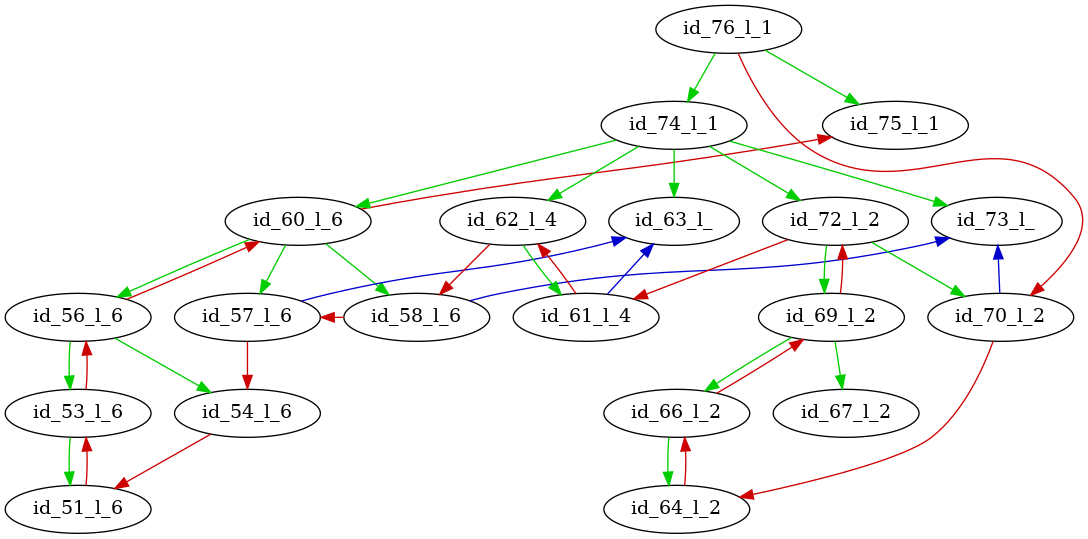

In [40]:
bad_example_cpg_for_ilp = """
digraph g {
# AST
{
  edge[color=green3,constraint=true]
  id_53_l_6 -> id_51_l_6 
   id_56_l_6 -> id_53_l_6 
   id_56_l_6 -> id_54_l_6 
   id_60_l_6 -> id_56_l_6 
   id_60_l_6 -> id_57_l_6 
   id_60_l_6 -> id_58_l_6 
   id_74_l_1 -> id_60_l_6 
   id_62_l_4 -> id_61_l_4 
   id_74_l_1 -> id_62_l_4 
   id_74_l_1 -> id_63_l_ 
   id_66_l_2 -> id_64_l_2 
   id_69_l_2 -> id_66_l_2 
   id_69_l_2 -> id_67_l_2 
   id_72_l_2 -> id_69_l_2 
   id_72_l_2 -> id_70_l_2 
   id_74_l_1 -> id_72_l_2 
   id_74_l_1 -> id_73_l_ 
   id_76_l_1 -> id_74_l_1 
   id_76_l_1 -> id_75_l_1
 }
# CFG
{
edge[color=red3,constraint=false]
  id_60_l_6 -> id_75_l_1 
   id_56_l_6 -> id_60_l_6 
   id_53_l_6 -> id_56_l_6 
   id_51_l_6 -> id_53_l_6 
   id_54_l_6 -> id_51_l_6 
   id_57_l_6 -> id_54_l_6 
   id_58_l_6 -> id_57_l_6 
   id_62_l_4 -> id_58_l_6 
   id_61_l_4 -> id_62_l_4 
   id_72_l_2 -> id_61_l_4 
   id_69_l_2 -> id_72_l_2 
   id_66_l_2 -> id_69_l_2 
   id_64_l_2 -> id_66_l_2 
   id_70_l_2 -> id_64_l_2 
   id_76_l_1 -> id_70_l_2 
 }
# REF
{
edge[color=blue3,constraint=false]
  id_57_l_6 -> id_63_l_ 
   id_58_l_6 -> id_73_l_ 
   id_61_l_4 -> id_63_l_ 
   id_70_l_2 -> id_73_l_ 
 }
}
"""

gv.jupyter_display_graph(bad_example_cpg_for_ilp)

Now, we want to replace the `id_?_l_?` node names with a list of properties for that node. Do that via ad-hoc parsing of the Prolog representation.

In [296]:
def get_node_properties_from_prolog(prolog_code):
    # mostly "borrowed" from graph_visualisation.py
        
    node_properties = collections.defaultdict(list)  # {node_id: [property, ...]}
    
    for line in prolog_code.split("\n"):
        line = line.strip().strip(".")
        
        if line == '' \
            or line.startswith("%") \
            or line.startswith("ref") \
            or line.startswith("ast") \
            or line.startswith("cfg") \
            or line.startswith("source_code"):
            continue  # ignore comments
        
        *functors, arguments = line.strip(")").split("(")
            
        # now we should only have node properties
        try:
            [node_name] = arguments.split(',')
            node_property = '◦'.join(functors)
            node_properties[node_name].append(node_property)
        except:
            # this should happen when there are multiple arguments to the function
            # in which case, this isn't a node property so ignore it
            continue
        
    return node_properties

        

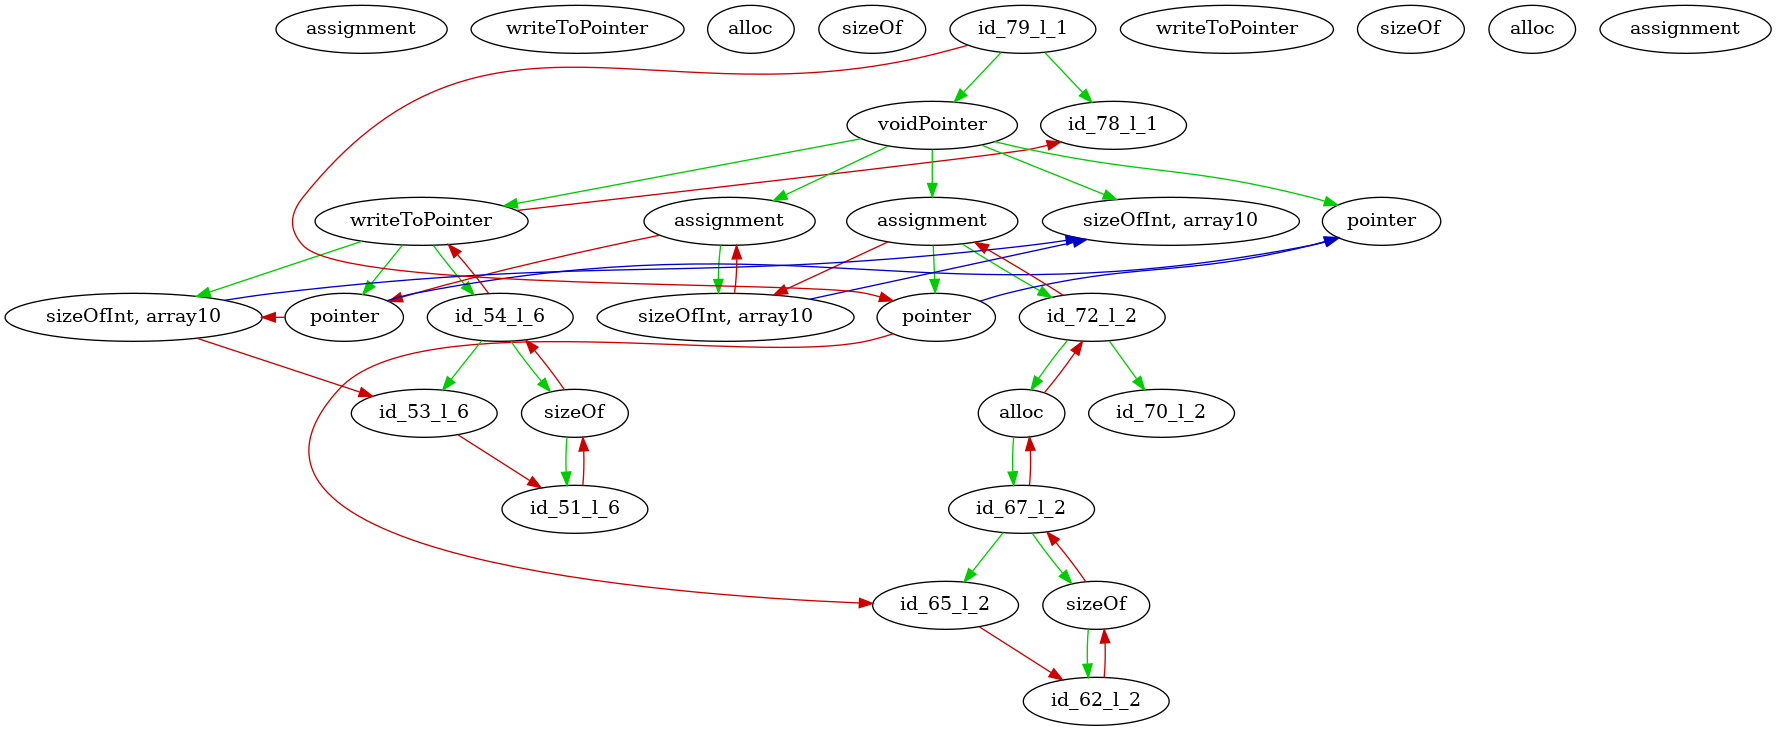

In [297]:
good_example_node_props = get_node_properties_from_prolog(prolog.loc[prolog['bug'] == False].iloc[0].codes)
good_example_node_labels = '\n    ' + '\n    '.join([
    node_id + ' [label="' + ', '.join(node_features) + '"]'
    for node_id, node_features in good_example_node_props.items()
])
good_example_cpg_for_ilp_with_props = good_example_cpg_for_ilp[0:12] + good_example_node_labels + good_example_cpg_for_ilp[12:]
gv.jupyter_display_graph(good_example_cpg_for_ilp_with_props)

Then manually prune to get rid of the stuff we don't care about:

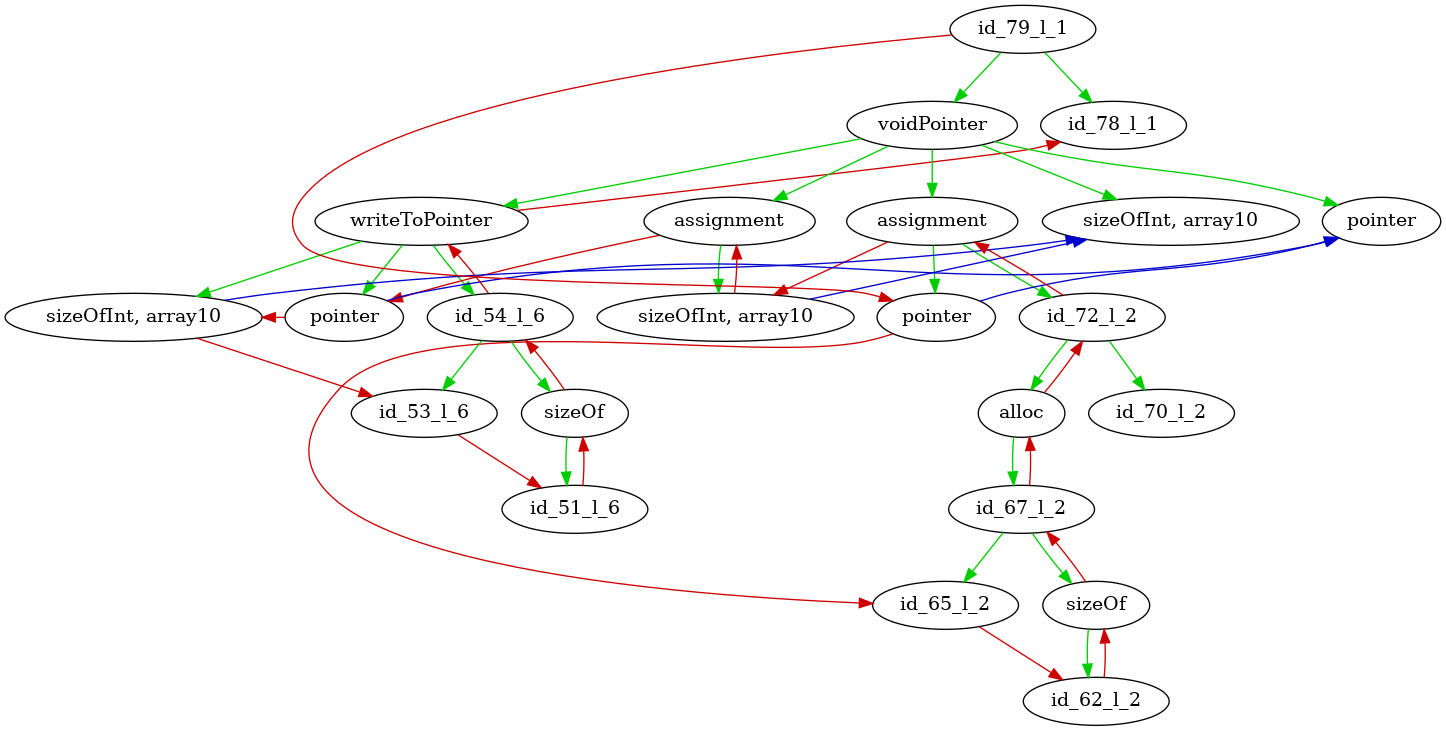

In [43]:
good_example_cpg_for_ilp_with_props = """
digraph g {
    id_52_l_6 [label="sizeOf"]
    id_58_l_6 [label="writeToPointer"]
    id_60_l_4 [label="assignment"]
    id_64_l_2 [label="sizeOf"]
    id_69_l_2 [label="alloc"]
    id_75_l_2 [label="assignment"]
    id_55_l_6 [label="sizeOfInt, array10"]
    id_56_l_6 [label="pointer"]
    id_59_l_4 [label="sizeOfInt, array10"]
    id_61_l_ [label="sizeOfInt, array10"]
    id_73_l_2 [label="pointer"]
    id_76_l_ [label="pointer"]
    id_77_l_1 [label="voidPointer"]
# AST
{
  edge[color=green3,constraint=true]
  id_52_l_6 -> id_51_l_6 
   id_54_l_6 -> id_52_l_6 
   id_54_l_6 -> id_53_l_6 
   id_58_l_6 -> id_54_l_6 
   id_58_l_6 -> id_55_l_6 
   id_58_l_6 -> id_56_l_6 
   id_77_l_1 -> id_58_l_6 
   id_60_l_4 -> id_59_l_4 
   id_77_l_1 -> id_60_l_4 
   id_77_l_1 -> id_61_l_ 
   id_64_l_2 -> id_62_l_2 
   id_67_l_2 -> id_64_l_2 
   id_67_l_2 -> id_65_l_2 
   id_69_l_2 -> id_67_l_2 
   id_72_l_2 -> id_69_l_2 
   id_72_l_2 -> id_70_l_2 
   id_75_l_2 -> id_72_l_2 
   id_75_l_2 -> id_73_l_2 
   id_77_l_1 -> id_75_l_2 
   id_77_l_1 -> id_76_l_ 
   id_79_l_1 -> id_77_l_1 
   id_79_l_1 -> id_78_l_1
 }
# CFG
{
edge[color=red3,constraint=false]
  id_58_l_6 -> id_78_l_1 
   id_54_l_6 -> id_58_l_6 
   id_52_l_6 -> id_54_l_6 
   id_51_l_6 -> id_52_l_6 
   id_53_l_6 -> id_51_l_6 
   id_55_l_6 -> id_53_l_6 
   id_56_l_6 -> id_55_l_6 
   id_60_l_4 -> id_56_l_6 
   id_59_l_4 -> id_60_l_4 
   id_75_l_2 -> id_59_l_4 
   id_72_l_2 -> id_75_l_2 
   id_69_l_2 -> id_72_l_2 
   id_67_l_2 -> id_69_l_2 
   id_64_l_2 -> id_67_l_2 
   id_62_l_2 -> id_64_l_2 
   id_65_l_2 -> id_62_l_2 
   id_73_l_2 -> id_65_l_2 
   id_79_l_1 -> id_73_l_2 
 }
# REF
{
edge[color=blue3,constraint=false]
  id_55_l_6 -> id_61_l_ 
   id_56_l_6 -> id_76_l_ 
   id_59_l_4 -> id_61_l_ 
   id_73_l_2 -> id_76_l_ 
 }
}
"""
save_png_and_svg_then_render_dot_graph(
    good_example_cpg_for_ilp_with_props, 
    "motivating-example-good-ilp-cpg"
)

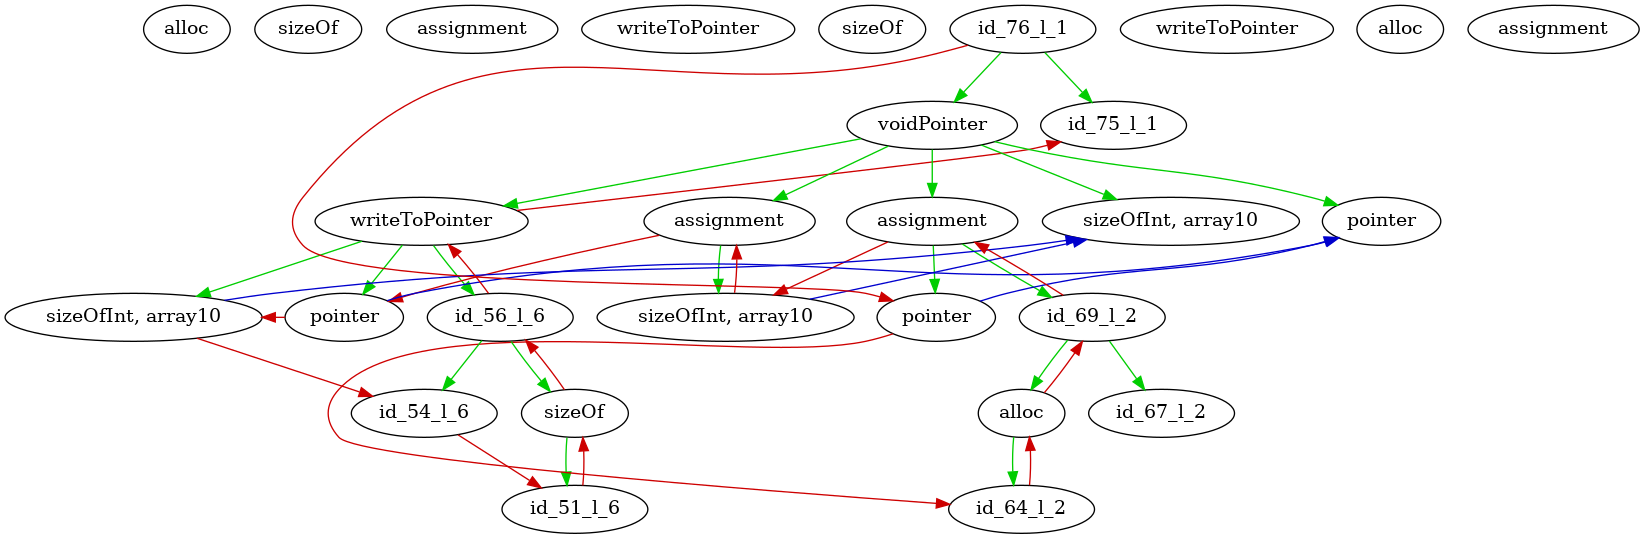

In [44]:
bad_example_node_props = get_node_properties_from_prolog(prolog.loc[prolog['bug'] == True].iloc[0].codes)
bad_example_node_labels = '\n    ' + '\n    '.join([
    node_id + ' [label="' + ', '.join(node_features) + '"]'
    for node_id, node_features in bad_example_node_props.items()
])
bad_example_cpg_for_ilp_with_props = bad_example_cpg_for_ilp[0:12] + bad_example_node_labels + bad_example_cpg_for_ilp[12:]
gv.jupyter_display_graph(bad_example_cpg_for_ilp_with_props)

The manually prune to get a nicer image:

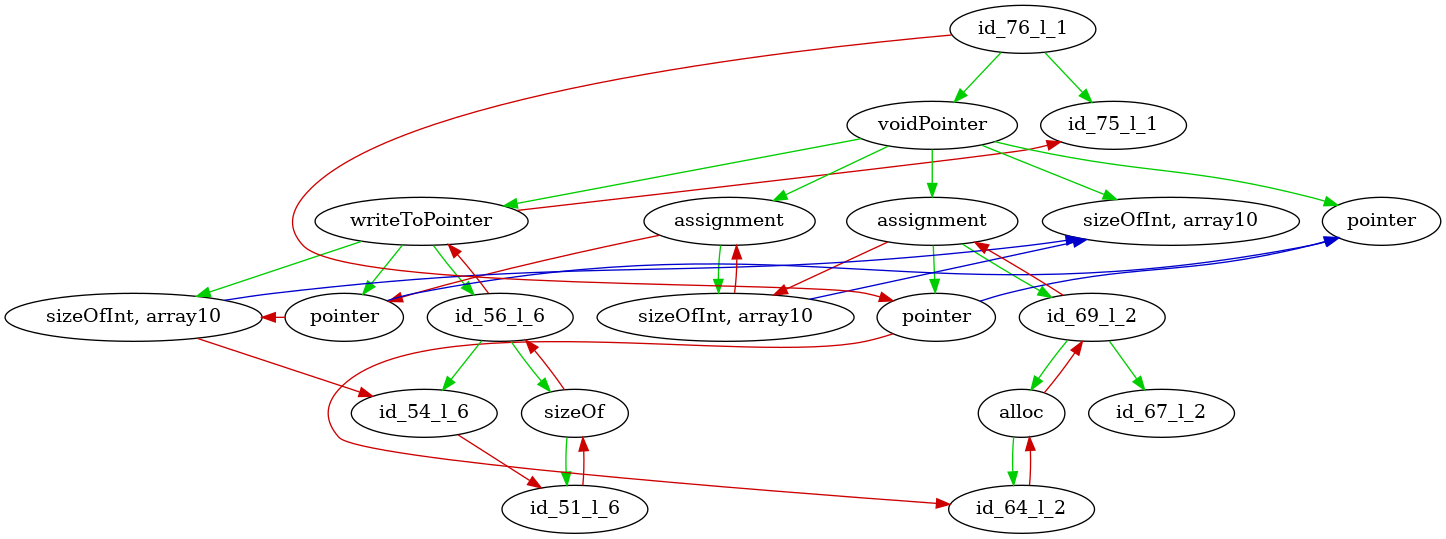

In [45]:
bad_example_cpg_for_ilp_with_props = """
digraph g {
    id_53_l_6 [label="sizeOf"]
    id_60_l_6 [label="writeToPointer"]
    id_62_l_4 [label="assignment"]
    id_66_l_2 [label="alloc"]
    id_72_l_2 [label="assignment"]
    id_57_l_6 [label="sizeOfInt, array10"]
    id_58_l_6 [label="pointer"]
    id_61_l_4 [label="sizeOfInt, array10"]
    id_63_l_ [label="sizeOfInt, array10"]
    id_70_l_2 [label="pointer"]
    id_73_l_ [label="pointer"]
    id_74_l_1 [label="voidPointer"]
# AST
{
  edge[color=green3,constraint=true]
  id_53_l_6 -> id_51_l_6 
   id_56_l_6 -> id_53_l_6 
   id_56_l_6 -> id_54_l_6 
   id_60_l_6 -> id_56_l_6 
   id_60_l_6 -> id_57_l_6 
   id_60_l_6 -> id_58_l_6 
   id_74_l_1 -> id_60_l_6 
   id_62_l_4 -> id_61_l_4 
   id_74_l_1 -> id_62_l_4 
   id_74_l_1 -> id_63_l_ 
   id_66_l_2 -> id_64_l_2 
   id_69_l_2 -> id_66_l_2 
   id_69_l_2 -> id_67_l_2 
   id_72_l_2 -> id_69_l_2 
   id_72_l_2 -> id_70_l_2 
   id_74_l_1 -> id_72_l_2 
   id_74_l_1 -> id_73_l_ 
   id_76_l_1 -> id_74_l_1 
   id_76_l_1 -> id_75_l_1
 }
# CFG
{
edge[color=red3,constraint=false]
  id_60_l_6 -> id_75_l_1 
   id_56_l_6 -> id_60_l_6 
   id_53_l_6 -> id_56_l_6 
   id_51_l_6 -> id_53_l_6 
   id_54_l_6 -> id_51_l_6 
   id_57_l_6 -> id_54_l_6 
   id_58_l_6 -> id_57_l_6 
   id_62_l_4 -> id_58_l_6 
   id_61_l_4 -> id_62_l_4 
   id_72_l_2 -> id_61_l_4 
   id_69_l_2 -> id_72_l_2 
   id_66_l_2 -> id_69_l_2 
   id_64_l_2 -> id_66_l_2 
   id_70_l_2 -> id_64_l_2 
   id_76_l_1 -> id_70_l_2 
 }
# REF
{
edge[color=blue3,constraint=false]
  id_57_l_6 -> id_63_l_ 
   id_58_l_6 -> id_73_l_ 
   id_61_l_4 -> id_63_l_ 
   id_70_l_2 -> id_73_l_ 
 }
}
"""
save_png_and_svg_then_render_dot_graph(
    bad_example_cpg_for_ilp_with_props, 
    "motivating-example-bad-ilp-cpg"
)

### Legend for Dot CPG Graphs

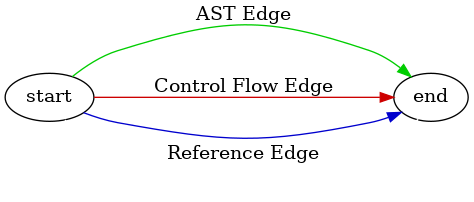

In [46]:
legend = """
digraph g {
  rankdir=LR;
# AST
{
  edge[color=green3,constraint=true]
  start -> end [label="AST Edge"]
 }
# CFG
{
edge[color=red3,constraint=true]
  start -> end [label="      Control Flow Edge      "]
 }
# REF
{
   edge[color=blue3,constraint=true]
  start -> end [label="   "]
 }

# dummy label for ref so it's under the other one
{
   edge[color=white,constraint=true]
  start -> end [label="Reference Edge"]
 }
}
"""

save_png_and_svg_then_render_dot_graph(
    legend, 
    "cpg-dot-graph-legend"
)

## Run example through neural networks to get activation map

Use the `keract` module to get activations from keras:

In [48]:
!pip install keract

You should consider upgrading via the 'pip install --upgrade pip' command.


In [49]:
import keract

Using TensorFlow backend.


### Preprocess Vulnerable Example into an Adjacency Matrix
This is predominately copying and pasting code from the data pre-proccessing notebooks:

In [50]:
import networkx as nx

In [52]:
good_ast_edgelist = preprocess_code.generate_edgelist(good_ast)
good_graph = nx.Graph()
good_graph.add_edges_from(good_ast_edgelist)
good_adj_matrix = nx.adjacency_matrix(good_graph).todense()

In [53]:
bad_ast_edgelist = preprocess_code.generate_edgelist(bad_ast)
bad_graph = nx.Graph()
bad_graph.add_edges_from(bad_ast_edgelist)
bad_adj_matrix = nx.adjacency_matrix(bad_graph).todense()

Let's plot these just in case we want them in the write-up:

In [55]:
import matplotlib.pyplot as plt

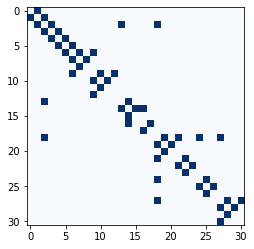

In [109]:
plt.imshow(good_adj_matrix, cmap="Blues")

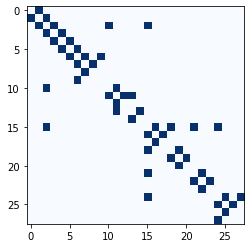

In [108]:
plt.imshow(bad_adj_matrix, cmap="Blues")

Aim is to stick the vulnerable example into the model and find out what part of the AST makes it "bad":

In [84]:
import numpy as np
from scipy.sparse import csr_matrix, hstack, vstack

In [85]:
def bottom_right_matrix_size_corrector(matrix, target_rows, target_columns):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((target_rows-rows, columns))
    col_corrector = csr_matrix((target_rows, target_columns-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [86]:
matrix_size = 614

In [95]:
adjacency_matrices = [bottom_right_matrix_size_corrector(bad_adj_matrix, matrix_size, matrix_size)]

In [96]:
labels = [False]

### Get a Prediction from the Trained Model

In [71]:
import pickle
import keras

In [65]:
with open('../data/adjacency-matrix-model-binary.pickle','rb') as f:
    model = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [72]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, batch_size):
        self.sparse_matrices = sparse_matrices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense

In [97]:
predict_batch_generator = SparseToDensePredictGenerator(adjacency_matrices, 96)
y_predict = model.predict_generator(predict_batch_generator)

In [98]:
y_predict

array([[0.9996562]], dtype=float32)

In [100]:
assert y_predict[0] > 0.9

If I remember correctly, the models prediction on our non-vulnerable example is wrong.

### Inspect Model Activations
Now we use the [`keract` library](https://github.com/philipperemy/keract) to visualise the activations of the last section of the convolution network.

In [105]:
bad_keract_input = np.reshape(np.array([adjacency_matrices[0].todense()]), (1, matrix_size, matrix_size, 1))

In [106]:
bad_activations = keract.get_activations(model, bad_keract_input, 'max_pooling2d_3')

max_pooling2d_3/MaxPool:0 (1, 76, 76, 32) 


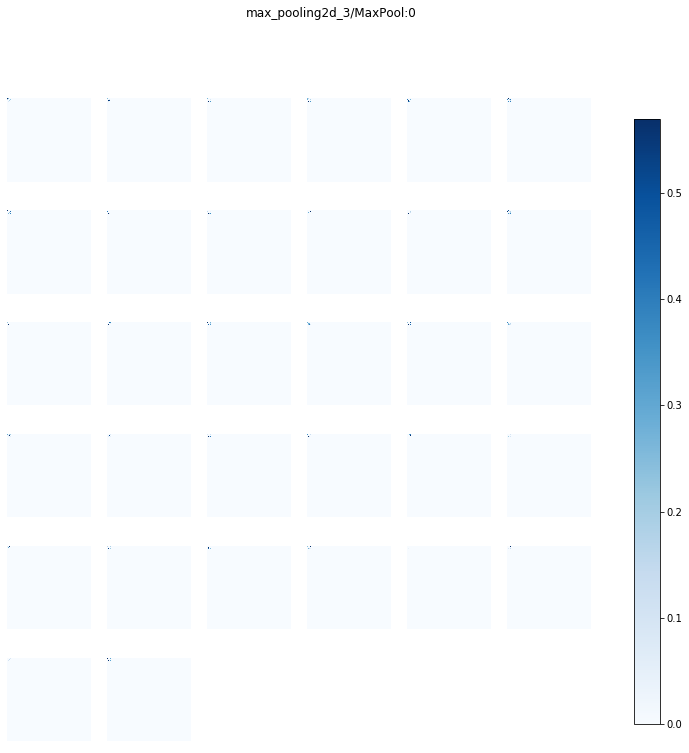

In [107]:
keract.display_activations(bad_activations, cmap="Blues", save=False)

Since our example is quite small, it makes sense that the activations happen in the top-left corner. This is hard to visualise though. Let's find the feature with the highest activation (which we assume is important), and project those activations onto the examples AST:

In [244]:
differences = []

for feature_index in range(32):
    bad_feature_activation_matrix = get_feature_activation_matrix(
        bad_activations['max_pooling2d_3/MaxPool:0'], feature_index)

    difference = abs(np.sum(bad_feature_activation_matrix))

    differences.append(difference)

max_difference = np.max(differences)
highest_feature_index = np.argmax(differences)

min_difference = np.min(differences)
lowest_feature_index = np.argmin(differences)

highest_feature_index, max_difference, lowest_feature_index, min_difference

(15, 6.1342835, 28, 0.020490142)

Now we plot the activations, but make sure to scale the feature matrix back to the full size of the image first:

In [182]:
from PIL import Image as pillow_Image

def imresize(imarray, *args ,**kwargs):
    return np.array(pillow_Image.fromarray(imarray).resize(*args, **kwargs))

In [255]:
feature_activation_matrix = get_feature_activation_matrix(bad_activations['max_pooling2d_3/MaxPool:0'], highest_feature_index) 
scaled_feature_activation_matrix = imresize(feature_activation_matrix, (matrix_size, matrix_size), pillow_Image.LANCZOS)

Utility functions for plotting the activation matrix as a dot graph over the original AST:

In [282]:
from matplotlib import colors
from collections import defaultdict


def get_feature_activation_matrix(activations, feature):
    return activations[0, :, :, feature]


def make_edge_string(edge, color, activation):
    start, end = edge
    start, end = start + 1, end + 1  # clang rep at the top is 1 based, this one is 0 based
    rgba_color = color + (activation, )
    hex_color = colors.to_hex(rgba_color, keep_alpha=True)
    return '{} -> {} [color="{}"]'.format(start, end, hex_color)


def make_edge_string_blended(edge, color, activation):
    start, end = edge
    start, end = start + 1, end + 1  # clang rep at the top is 1 based, this one is 0 based
    
    # vary remaining green and blue based on activation values
    red, green, blue = color
    
    green = green + (1.0-activation)*(1.0-green)
    blue = blue + activation*(1.0-blue)
    
    rgba_color = (red, green, blue, 1, )
    hex_color = colors.to_hex(rgba_color, keep_alpha=True)
    return '{} -> {} [color="{}"]'.format(start, end, hex_color)


def generate_ast_activation_graph(ast, activations):
    template = """
    digraph g {{
        {{
            edge[constraint=true]
            {}
        }}
    }}
    """

    ast = ast[0,:,:,0]
    num_nodes  = ast.shape[0]

    activation_color = (14/255.0, 24/255.0, 200/255.0)

    ast_edge_values = defaultdict(int)
    for index, value in np.ndenumerate(ast):
        ast_edge_values[tuple(sorted(index))] = value

    activation_edge_values = defaultdict(int)
    for index, value in np.ndenumerate(activations):
        if tuple(sorted(index)) in ast_edge_values:
            activation_edge_values[tuple(sorted(index))] += value
            
    max_activation = float(max(activation_edge_values.values()))
    print(max_activation)
    for index, value in activation_edge_values.items():
        if tuple(sorted(index)) in ast_edge_values and value > 0:
            alpha = value/max_activation
            activation_edge_values[tuple(sorted(index))] = alpha
            
    ast_edges = [
        make_edge_string(index, activation_color, activation=max([activation_edge_values.get(index, 0), 0]))
        for index, value in ast_edge_values.items()
        if value > 0
    ]

    return template.format(
        '\n            '.join(ast_edges)
    )

def plot_ast_activation_graph(filename_no_ext, ast_adjacency_matrix, activation_matrix):
    dot_source = generate_ast_activation_graph(
        ast_adjacency_matrix,
        activation_matrix,
    )
    return save_png_and_svg_then_render_dot_graph(dot_source, filename_no_ext)

And actually do the dot graph, then render and save it:

In [283]:
bad_activation_dot_source = generate_ast_activation_graph(
    bad_keract_input,
    scaled_feature_activation_matrix,
)
print(bad_activation_dot_source)

3.4132660627365112

    digraph g {
        {
            edge[constraint=true]
            1 -> 2 [color="#0e18c8ff"]
            2 -> 3 [color="#0e18c8f4"]
            3 -> 4 [color="#0e18c8e9"]
            3 -> 11 [color="#0e18c88a"]
            3 -> 16 [color="#0e18c828"]
            4 -> 5 [color="#0e18c8dc"]
            5 -> 6 [color="#0e18c8cb"]
            6 -> 7 [color="#0e18c8b5"]
            7 -> 8 [color="#0e18c89a"]
            7 -> 10 [color="#0e18c877"]
            8 -> 9 [color="#0e18c87b"]
            11 -> 12 [color="#0e18c81d"]
            12 -> 13 [color="#0e18c80d"]
            12 -> 14 [color="#0e18c80a"]
            14 -> 15 [color="#0e18c812"]
            16 -> 17 [color="#0e18c837"]
            16 -> 19 [color="#0e18c84a"]
            16 -> 22 [color="#0e18c85d"]
            16 -> 25 [color="#0e18c85e"]
            17 -> 18 [color="#0e18c849"]
            19 -> 20 [color="#0e18c860"]
            20 -> 21 [color="#0e18c866"]
            22 -> 23 [color="#0e18c86

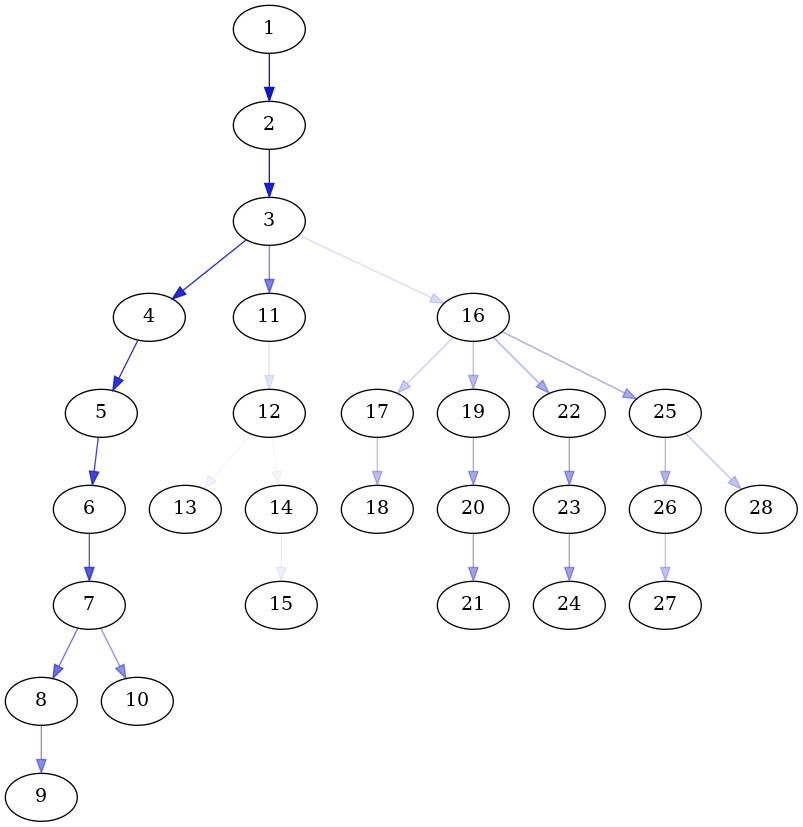

In [279]:
save_png_and_svg_then_render_dot_graph(bad_activation_dot_source, "eval-ilp-motivating-example-bad-activations")

Manually paste the edges from this, into the AST we generated at the beginning of the notebook:

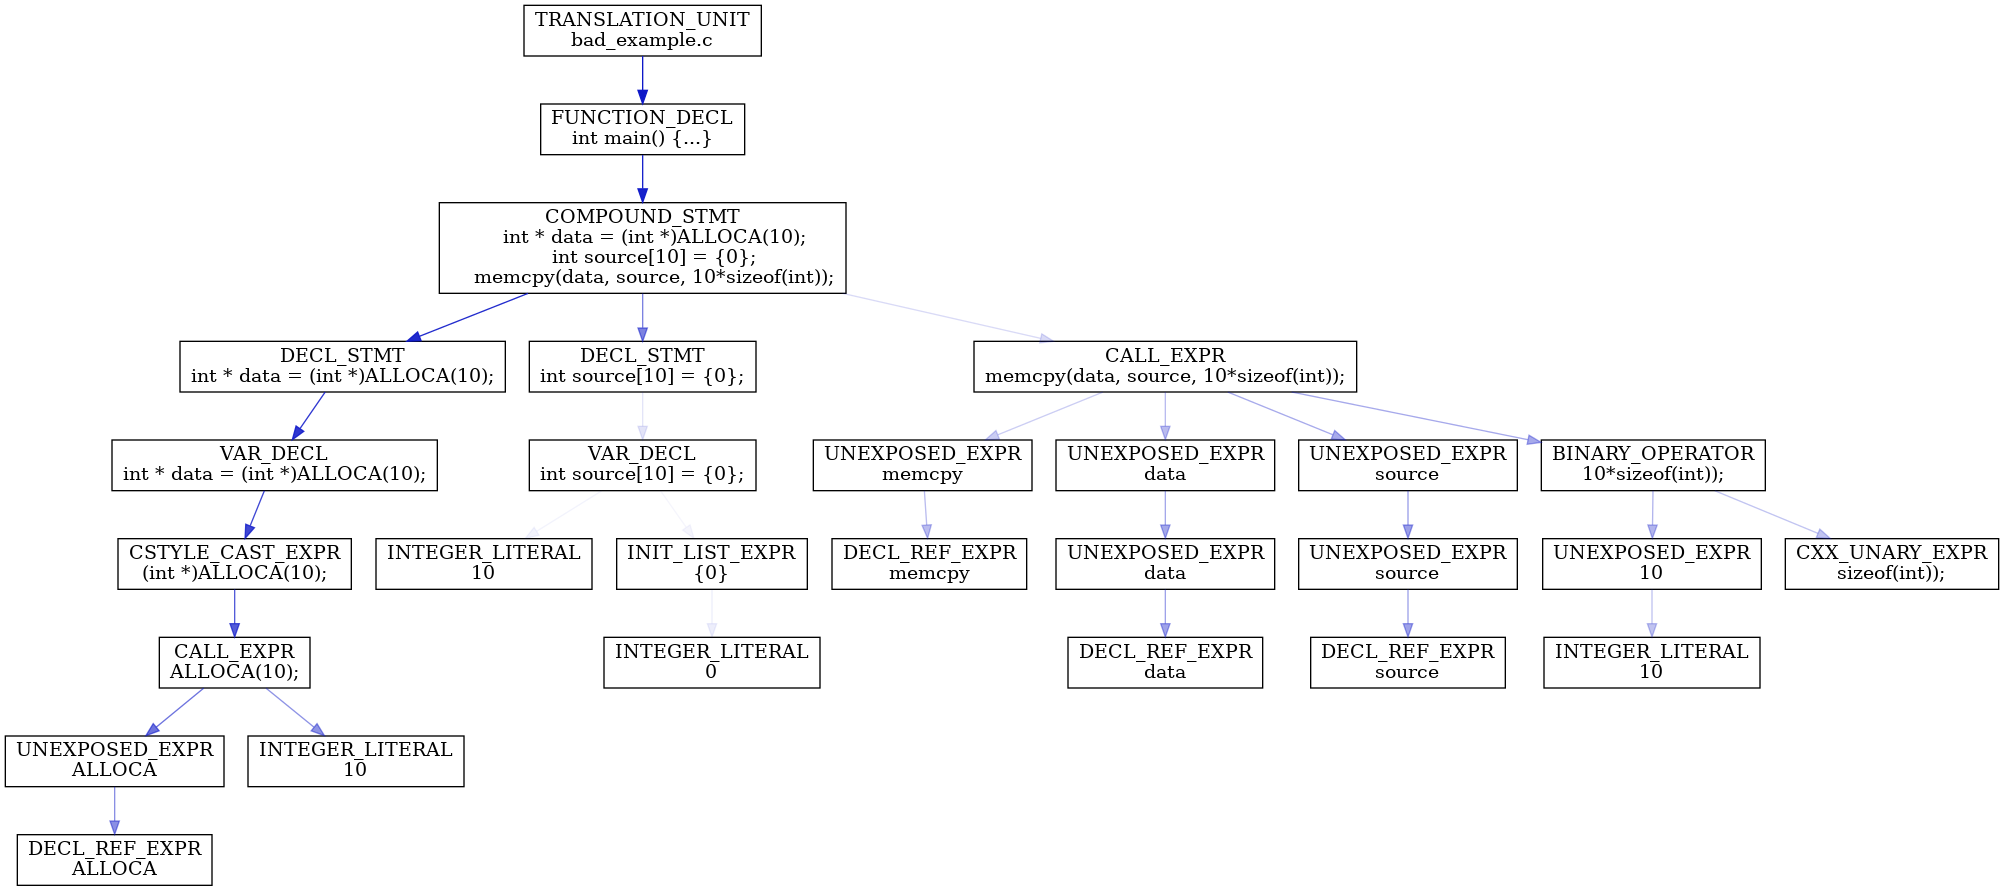

In [280]:
bad_adj_cnn_activations_dot = """
        digraph g {
        
            # Original AST representation from clang at top of notebook
            {  # NODE LABELS
                node[shape=box]
                1 [label="TRANSLATION_UNIT
bad_example.c"]
                2 [label="FUNCTION_DECL
int main() {...}"]
                3 [label="COMPOUND_STMT
    int * data = (int *)ALLOCA(10);
    int source[10] = {0};
    memcpy(data, source, 10*sizeof(int));"]
                4 [label="DECL_STMT
int * data = (int *)ALLOCA(10);"]
                5 [label="VAR_DECL
int * data = (int *)ALLOCA(10);"]
                6 [label="CSTYLE_CAST_EXPR
(int *)ALLOCA(10);"]
                7 [label="CALL_EXPR
ALLOCA(10);"]
                8 [label="UNEXPOSED_EXPR
ALLOCA"]
                9 [label="DECL_REF_EXPR
ALLOCA"]
                10 [label="INTEGER_LITERAL
10"]
                11 [label="DECL_STMT
int source[10] = {0};"]
                12 [label="VAR_DECL
int source[10] = {0};"]
                13 [label="INTEGER_LITERAL
10"]
                14 [label="INIT_LIST_EXPR
{0}"]
                15 [label="INTEGER_LITERAL
0"]
                16 [label="CALL_EXPR
memcpy(data, source, 10*sizeof(int));"]
                17 [label="UNEXPOSED_EXPR
memcpy"]
                18 [label="DECL_REF_EXPR
memcpy"]
                19 [label="UNEXPOSED_EXPR
data"]
                20 [label="UNEXPOSED_EXPR
data"]
                21 [label="DECL_REF_EXPR
data"]
                22 [label="UNEXPOSED_EXPR
source"]
                23 [label="UNEXPOSED_EXPR
source"]
                24 [label="DECL_REF_EXPR
source"]
                25 [label="BINARY_OPERATOR
10*sizeof(int));"]
                26 [label="UNEXPOSED_EXPR
10"]
                27 [label="INTEGER_LITERAL
10"]
                28 [label="CXX_UNARY_EXPR
sizeof(int));"]
            }
            {  # AST
                edge[constraint=true]
                # Pasted in activations from adj-cnn model:
                1 -> 2 [color="#0e18c8ff"]
                2 -> 3 [color="#0e18c8f4"]
                3 -> 4 [color="#0e18c8e9"]
                3 -> 11 [color="#0e18c88a"]
                3 -> 16 [color="#0e18c828"]
                4 -> 5 [color="#0e18c8dc"]
                5 -> 6 [color="#0e18c8cb"]
                6 -> 7 [color="#0e18c8b5"]
                7 -> 8 [color="#0e18c89a"]
                7 -> 10 [color="#0e18c877"]
                8 -> 9 [color="#0e18c87b"]
                11 -> 12 [color="#0e18c81d"]
                12 -> 13 [color="#0e18c80d"]
                12 -> 14 [color="#0e18c80a"]
                14 -> 15 [color="#0e18c812"]
                16 -> 17 [color="#0e18c837"]
                16 -> 19 [color="#0e18c84a"]
                16 -> 22 [color="#0e18c85d"]
                16 -> 25 [color="#0e18c85e"]
                17 -> 18 [color="#0e18c849"]
                19 -> 20 [color="#0e18c860"]
                20 -> 21 [color="#0e18c866"]
                22 -> 23 [color="#0e18c869"]
                23 -> 24 [color="#0e18c866"]
                25 -> 26 [color="#0e18c851"]
                25 -> 28 [color="#0e18c841"]
                26 -> 27 [color="#0e18c842"]
            }
        }
"""
save_png_and_svg_then_render_dot_graph(bad_adj_cnn_activations_dot, "eval-ilp-motivating-example-bad-activations-overlayed")

For comparison, what does the lowest activating feature look like?

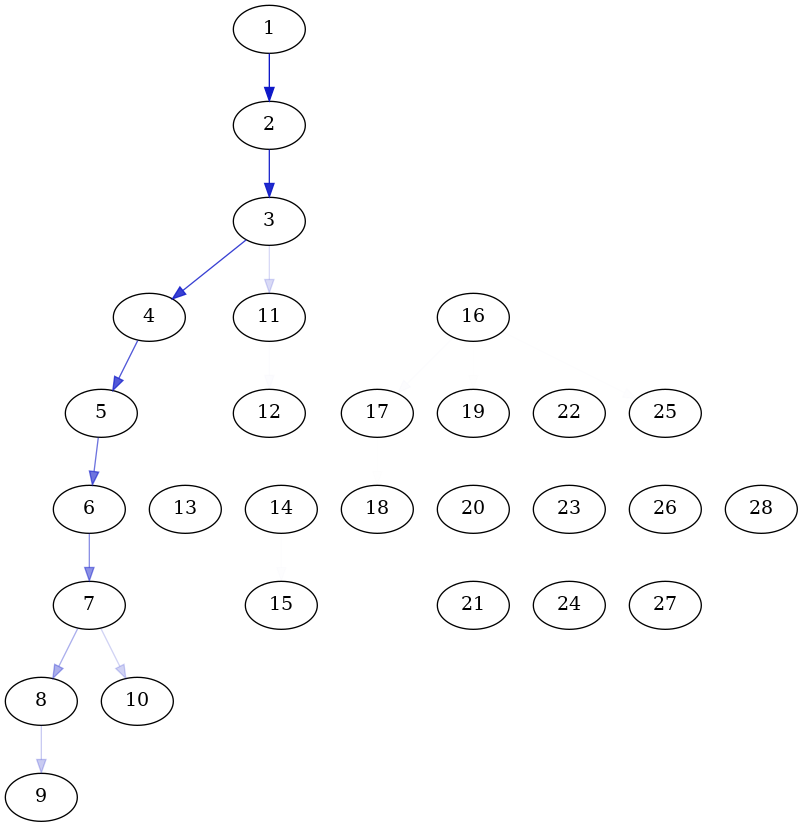

In [281]:
feature_activation_matrix_worst = get_feature_activation_matrix(bad_activations['max_pooling2d_3/MaxPool:0'], lowest_feature_index) 
scaled_feature_activation_matrix_worst = imresize(feature_activation_matrix_worst, (matrix_size, matrix_size), pillow_Image.LANCZOS)
bad_activation_dot_source_worst = generate_ast_activation_graph(
    bad_keract_input,
    scaled_feature_activation_matrix_worst,
)
save_png_and_svg_then_render_dot_graph(bad_activation_dot_source_worst, "/tmp/dont-save-me-really")

It's worth noting that the "blueness" is normalised, so that whilst this looks like a high activation, it has a total activation of 0.020490142. In contrast, the "best" activation (the one a bit above) has a total activation of 6.1342835.

## Small AST for use in other diagrams

Copy-and-paste the ASTs from earlier but remove the labels and remove some edges so they are nice and small. This is just to have a little AST for use in architecture diagrams.

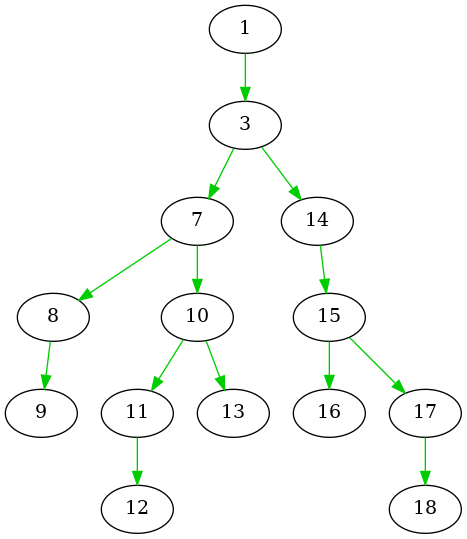

In [303]:
small_clang_dot = """
        digraph g {
            {  # AST
                edge[color=green3, constraint=true]
                1 -> 3
                3 -> 7
                7 -> 8
                8 -> 9
                7 -> 10
                10 -> 11
                11 -> 12
                10 -> 13
                3 -> 14
                14 -> 15
                15 -> 16
                15 -> 17
                17 -> 18
            }
        }
"""
save_png_and_svg_then_render_dot_graph(
    small_clang_dot,
    "example-small-clang-ast"
)

## TODO: Run example through ILP rules to see if it passes

Don't need to do this explicitly, since it's relatively clear that the rule correctly classifies both examples. Maybe we want to visualise how it correctly classifies it?